In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ../..

/scratch/km817/iREC


In [4]:
import pickle as pkl
import matplotlib.pyplot as plt
import torch
import torch.distributions as D
import hamiltorch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
def make_empirical_predictive(weights, x_input, y_output):
    pred_list, _ = hamiltorch.predict_model(net, x = x_input.flatten().to(device),
                                                  y = y_output.flatten().to(device), samples=weights,
                                                  model_loss='regression', tau_out=tau_out,
                                                  tau_list=tau_list)
    
    # need to make gmm at each sample
    return pred_list

def make_empirical_gmm(preds):
    mix = D.Categorical(torch.ones(preds.shape[0]))
    comp = D.Normal(loc=preds.squeeze().permute(1, 0), scale=beta ** -0.5)
    gmm = D.MixtureSameFamily(mix, comp)
    return gmm

def compute_gmm_lp(weights, x, y):
    preds = make_empirical_predictive(weights, x, y)
    
    gmm = make_empirical_gmm(preds)
    
    return gmm.log_prob(y.squeeze()).sum()

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [7]:
from models.BNNs.DeterministicNN import Deterministic_NN

In [8]:
def plot_preds(weights, ax=None, title='',
               plt_train_kwargs={'alpha' : 1, 'marker' :'*', 'color':'k', 'rasterized' : True},
               plt_test_kwargs={'alpha' : 0.5, 'marker' :'+', 'color':'k', 'rasterized' : True},
               plt_mean_kwargs={'color':'b', 'rasterized' : True},
               plt_true_kwargs={'color':'r', 'rasterized' : True},
               epistemic_kwargs={'alpha' : 0.5, 'rasterized' : True},
               aleatoric_kwargs={'alpha' : 0.2, 'rasterized' : True},
               fs=16,
               ):
    preds = make_empirical_predictive(weights, xs, ys)
    
    test_ll = compute_gmm_lp(weights, x_test, y_test)
    train_ll = compute_gmm_lp(weights, x_data, y_data)
    if ax is None:
        ax = plt.gca()

    m = preds.mean(0).to('cpu')
    s = preds.std(0).to('cpu')
    s_al = (preds.var(0).to('cpu') + tau_out ** -1) ** 0.5

    # Get upper and lower confidence bounds
    lower, upper = (m - s*2).flatten(), (m + s*2).flatten()
    # + aleotoric
    lower_al, upper_al = (m - s_al*2).flatten(), (m + s_al*2).flatten()

    # Plot training data as black stars
    ax.scatter(x_data.numpy(), y_data.numpy(), **plt_train_kwargs, label='Train Data')
#     # Plot testing data as black crosses
#     ax.scatter(x_test.numpy(), y_test.numpy(), **plt_test_kwargs, label='Test Data')
    # Plot predictive means as blue line
    ax.plot(xs.numpy(), m.numpy(), **plt_mean_kwargs, label='Mean')
    ax.plot(xs.numpy(), ys.numpy(), **plt_true_kwargs, label='Ground Truth')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(xs.flatten().numpy(), lower.numpy(), upper.numpy(), **epistemic_kwargs, label='Epistemic')
    ax.fill_between(xs.flatten().numpy(), lower_al.numpy(), upper_al.numpy(), **aleatoric_kwargs, label = 'Aleatoric')
    #ax.legend(['Observed Data', 'Mean', 'Ground Truth', 'Epistemic', 'Aleatoric'], fontsize = fs)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    ax.set_title(title, fontsize=fs)
    ax.set_xlim(-10., 10.)
    bbox = {'facecolor': 'white', 'alpha': 0.6, 'pad': 0.5, 'boxstyle': 'round', 'edgecolor':'black'}
    ax.text(-5, 1.2, f'Test LL: {test_ll:.2f}', bbox=bbox, fontsize=fs, horizontalalignment='center')
    ax.text(-5, 0.05, f'Train LL: {train_ll:.2f}', bbox=bbox, fontsize=fs, horizontalalignment='center')
    ax.grid()
    return(ax)

In [9]:
# create toy dataset
torch.set_default_tensor_type(torch.DoubleTensor)
torch.manual_seed(20)
x = torch.cat([torch.Tensor(75).uniform_(-5, -2).sort()[0].reshape(-1, 1),
               torch.Tensor(50).uniform_(2, 5).sort()[0].reshape(-1, 1)])
i = 30
x_data = torch.cat([x[0:i - 15], x[i + 14:]])

# generate some data
alpha, beta, num_nodes = 1., 100., 2

# generate some data
data_generator_model = Deterministic_NN(alpha=alpha, beta=beta, num_nodes=num_nodes)
sampled_weights = data_generator_model.sample_weights_from_prior()
data_generator_model.make_weights_from_sample(sampled_weights)
y_data = data_generator_model(x_data).detach() + (
            1 / data_generator_model.likelihood_beta ** 0.5) * torch.randn_like(
    data_generator_model(x_data).detach())

x_test = torch.Tensor(200).uniform_(-10., 10.).sort()[0]
y_test = data_generator_model(x_test).detach() + (
            1 / data_generator_model.likelihood_beta ** 0.5) * torch.randn_like(
    data_generator_model(x_test).detach()).sort()[0]

xs = torch.linspace(-10, 10, 100)
ys = data_generator_model(xs).detach()

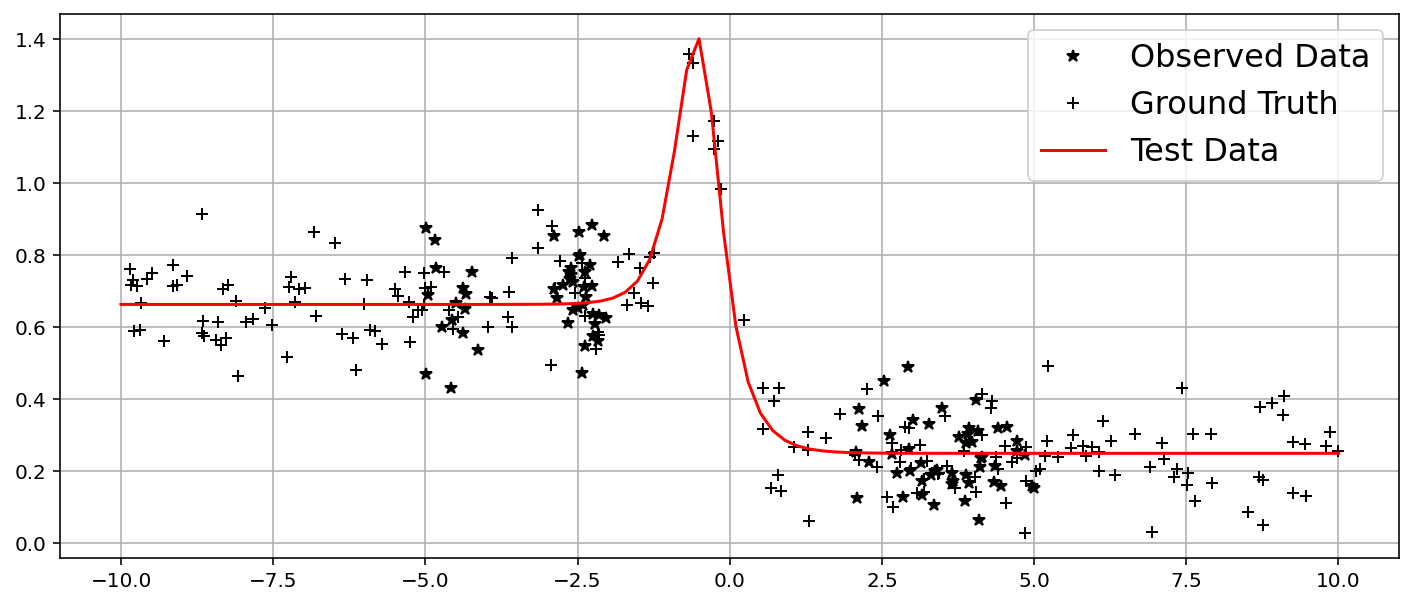

In [10]:
plt.figure(figsize=(12,5))
plt.plot(x_data,y_data, 'k*')
plt.plot(x_test,y_test, 'k+')
plt.plot(xs, ys, 'r')
plt.legend(['Observed Data', 'Ground Truth', 'Test Data'], fontsize = 16)
plt.grid()
plt.show()

In [11]:
device = torch.device('cpu')
class Net(nn.Module):
    def __init__(self, num_nodes: int = 10):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, num_nodes)
        self.fc2 = nn.Linear(num_nodes, num_nodes)
        self.fc3 = nn.Linear(num_nodes, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x.view(-1, 1)))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net(num_nodes=num_nodes)

In [12]:
# params for plotting 
model_loss = 'regression'
tau = alpha # Prior Precision
tau_out = beta # Output Precision
r = 0 # Random seed


tau_list = []
for w in net.parameters():
    tau_list.append(tau) # set the prior precision to be the same for each set of weights
tau_list = torch.tensor(tau_list).to(device)

# Epsilon = 0

In [57]:
# load data
epsilon = 0.
emp_kde_betas = [1., 2.5, 10., 25.]
var_betas = [0.0075, 0.01, 0.05, 1., 2.]
emp_weights = []
emp_kls = []
for b in emp_kde_betas:
    emp_weights.append(pkl.load(open(f'PickledStuff/BNN_BETA_RESULTS/EMP/emp_beta_{b}_eps_{epsilon:.0f}.pkl', 'rb')))
    emp_kls.append(pkl.load(open(f'PickledStuff/BNN_BETA_RESULTS/EMP/hmc_kl_beta_{b}.pkl', 'rb')))
emp_kls = [t.detach() for t in emp_kls]
kde_weights = []
for b in emp_kde_betas:
    kde_weights.append(pkl.load(open(f'PickledStuff/BNN_BETA_RESULTS/KDE/kde_beta_{b}_eps_{epsilon:.0f}.pkl', 'rb')))

var_weights = []
var_kls = []
for b in var_betas:
    var_weights.append(pkl.load(open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_beta_{b}_eps_{epsilon:.0f}.pkl', 'rb')))
    var_kls.append(pkl.load(open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_kl_beta_{b}.pkl', 'rb')))
var_kls = [t.detach() for t in var_kls]

In [58]:
emp_train_lls = torch.zeros([0])
emp_test_lls = torch.zeros([0])
for w in emp_weights:
    emp_train_lls = torch.cat([emp_train_lls, compute_gmm_lp(w, x_data, y_data)[None]])
    emp_test_lls = torch.cat([emp_test_lls, compute_gmm_lp(w, x_test, y_test)[None]])

In [59]:
emp_train_lls = torch.zeros([0])
emp_test_lls = torch.zeros([0])
for w in emp_weights:
    emp_train_lls = torch.cat([emp_train_lls, compute_gmm_lp(w, x_data, y_data)[None]])
    emp_test_lls = torch.cat([emp_test_lls, compute_gmm_lp(w, x_test, y_test)[None]])

In [60]:
kde_train_lls = torch.zeros([0])
kde_test_lls = torch.zeros([0])
for w in kde_weights:
    kde_train_lls = torch.cat([kde_train_lls, compute_gmm_lp(w, x_data, y_data)[None]])
    kde_test_lls = torch.cat([kde_test_lls, compute_gmm_lp(w, x_test, y_test)[None]])

In [61]:
var_train_lls = torch.zeros([0])
var_test_lls = torch.zeros([0])
for w in var_weights:
    var_train_lls = torch.cat([var_train_lls, compute_gmm_lp(w, x_data, y_data)[None]])
    var_test_lls = torch.cat([var_test_lls, compute_gmm_lp(w, x_test, y_test)[None]])

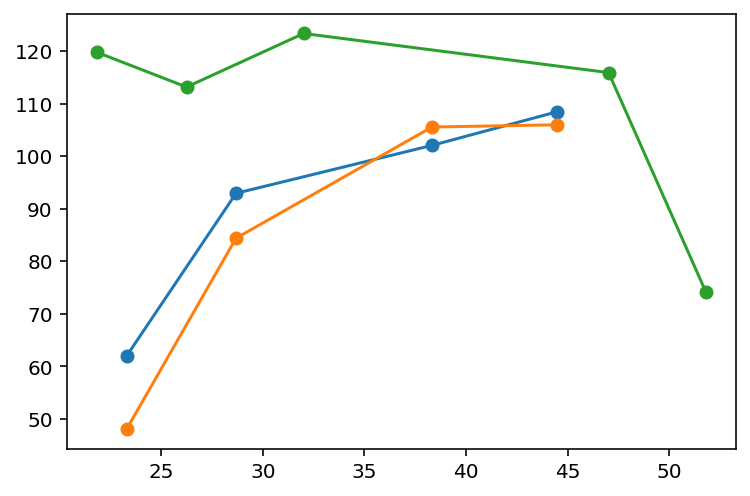

In [62]:
plt.plot(emp_kls, emp_test_lls, '-o')
plt.plot(emp_kls, kde_test_lls, '-o')
plt.plot(var_kls, var_test_lls, '-o')

# Epsilon = 0

In [49]:
# load data
epsilon = 0.1
emp_kde_betas = [1., 2.5, 10., 25.]
var_betas = [0.0075, 0.01, 0.05, 1., 2.]
emp_weights = []
emp_kls = []
for b in emp_kde_betas:
    emp_weights.append(pkl.load(open(f'PickledStuff/BNN_BETA_RESULTS/EMP/emp_beta_{b}_eps_{epsilon:.1f}.pkl', 'rb')))
    emp_kls.append(pkl.load(open(f'PickledStuff/BNN_BETA_RESULTS/EMP/hmc_kl_beta_{b}.pkl', 'rb')))
emp_kls = [t.detach() for t in emp_kls]
kde_weights = []
for b in emp_kde_betas:
    kde_weights.append(pkl.load(open(f'PickledStuff/BNN_BETA_RESULTS/KDE/kde_beta_{b}_eps_{epsilon:.1f}.pkl', 'rb')))

var_weights = []
var_kls = []
for b in var_betas:
    var_weights.append(pkl.load(open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_beta_{b}_eps_{epsilon:.1f}.pkl', 'rb')))
    var_kls.append(pkl.load(open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_kl_beta_{b}.pkl', 'rb')))
var_kls = [t.detach() for t in var_kls]

In [50]:
emp_train_lls = torch.zeros([0])
emp_test_lls = torch.zeros([0])
for w in emp_weights:
    emp_train_lls = torch.cat([emp_train_lls, compute_gmm_lp(w, x_data, y_data)[None]])
    emp_test_lls = torch.cat([emp_test_lls, compute_gmm_lp(w, x_test, y_test)[None]])

In [51]:
emp_train_lls = torch.zeros([0])
emp_test_lls = torch.zeros([0])
for w in emp_weights:
    emp_train_lls = torch.cat([emp_train_lls, compute_gmm_lp(w, x_data, y_data)[None]])
    emp_test_lls = torch.cat([emp_test_lls, compute_gmm_lp(w, x_test, y_test)[None]])

In [52]:
kde_train_lls = torch.zeros([0])
kde_test_lls = torch.zeros([0])
for w in kde_weights:
    kde_train_lls = torch.cat([kde_train_lls, compute_gmm_lp(w, x_data, y_data)[None]])
    kde_test_lls = torch.cat([kde_test_lls, compute_gmm_lp(w, x_test, y_test)[None]])

In [53]:
var_train_lls = torch.zeros([0])
var_test_lls = torch.zeros([0])
for w in var_weights:
    var_train_lls = torch.cat([var_train_lls, compute_gmm_lp(w, x_data, y_data)[None]])
    var_test_lls = torch.cat([var_test_lls, compute_gmm_lp(w, x_test, y_test)[None]])

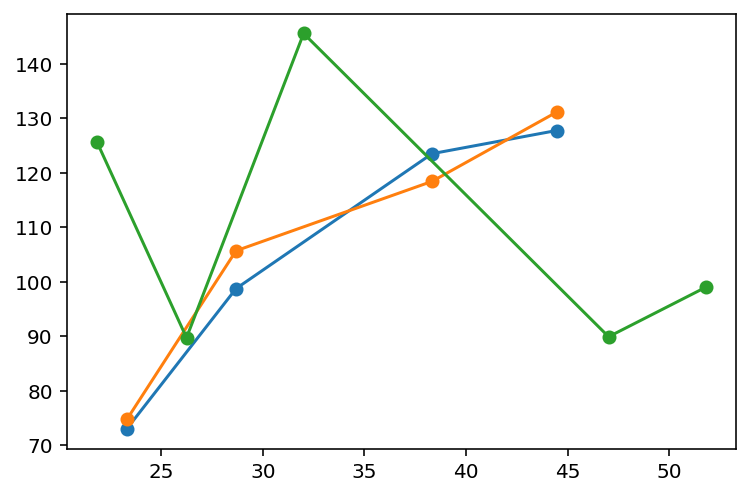

In [54]:
plt.plot(emp_kls, emp_test_lls, '-o')
plt.plot(emp_kls, kde_test_lls, '-o')
plt.plot(var_kls, var_test_lls, '-o')

# Epsilon = 0.2

In [161]:
# load data
epsilon = 0.2
emp_kde_betas = [0.1, 1., 2.5, 10., 25.]
var_betas = [0.0075, 0.01, 0.05, 1., 2.]
emp_weights = []
emp_kls = []
for b in emp_kde_betas:
    emp_weights.append(pkl.load(open(f'PickledStuff/BNN_BETA_RESULTS/EMP/emp_beta_{b}_eps_{epsilon:.1f}.pkl', 'rb')))
    emp_kls.append(pkl.load(open(f'PickledStuff/BNN_BETA_RESULTS/EMP/hmc_kl_beta_{b}.pkl', 'rb')))
emp_kls = [t.detach() for t in emp_kls]
kde_weights = []
for b in emp_kde_betas:
    kde_weights.append(pkl.load(open(f'PickledStuff/BNN_BETA_RESULTS/KDE/kde_beta_{b}_eps_{epsilon:.1f}.pkl', 'rb')))

var_weights = []
var_kls = []
for b in var_betas:
    var_weights.append(pkl.load(open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_beta_{b}_eps_{epsilon:.1f}_new.pkl', 'rb')))
    var_kls.append(pkl.load(open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_kl_beta_{b}.pkl', 'rb')))
var_kls = [t.detach() for t in var_kls]

In [162]:
emp_train_lls = torch.zeros([0])
emp_test_lls = torch.zeros([0])
for w in emp_weights:
    emp_train_lls = torch.cat([emp_train_lls, compute_gmm_lp(w, x_data, y_data)[None]])
    emp_test_lls = torch.cat([emp_test_lls, compute_gmm_lp(w, x_test, y_test)[None]])

In [163]:
emp_train_lls = torch.zeros([0])
emp_test_lls = torch.zeros([0])
for w in emp_weights:
    emp_train_lls = torch.cat([emp_train_lls, compute_gmm_lp(w, x_data, y_data)[None]])
    emp_test_lls = torch.cat([emp_test_lls, compute_gmm_lp(w, x_test, y_test)[None]])

In [164]:
kde_train_lls = torch.zeros([0])
kde_test_lls = torch.zeros([0])
for w in kde_weights:
    kde_train_lls = torch.cat([kde_train_lls, compute_gmm_lp(w, x_data, y_data)[None]])
    kde_test_lls = torch.cat([kde_test_lls, compute_gmm_lp(w, x_test, y_test)[None]])

In [165]:
var_train_lls = torch.zeros([0])
var_test_lls = torch.zeros([0])
for w in var_weights:
    var_train_lls = torch.cat([var_train_lls, compute_gmm_lp(w, x_data, y_data)[None]])
    var_test_lls = torch.cat([var_test_lls, compute_gmm_lp(w, x_test, y_test)[None]])

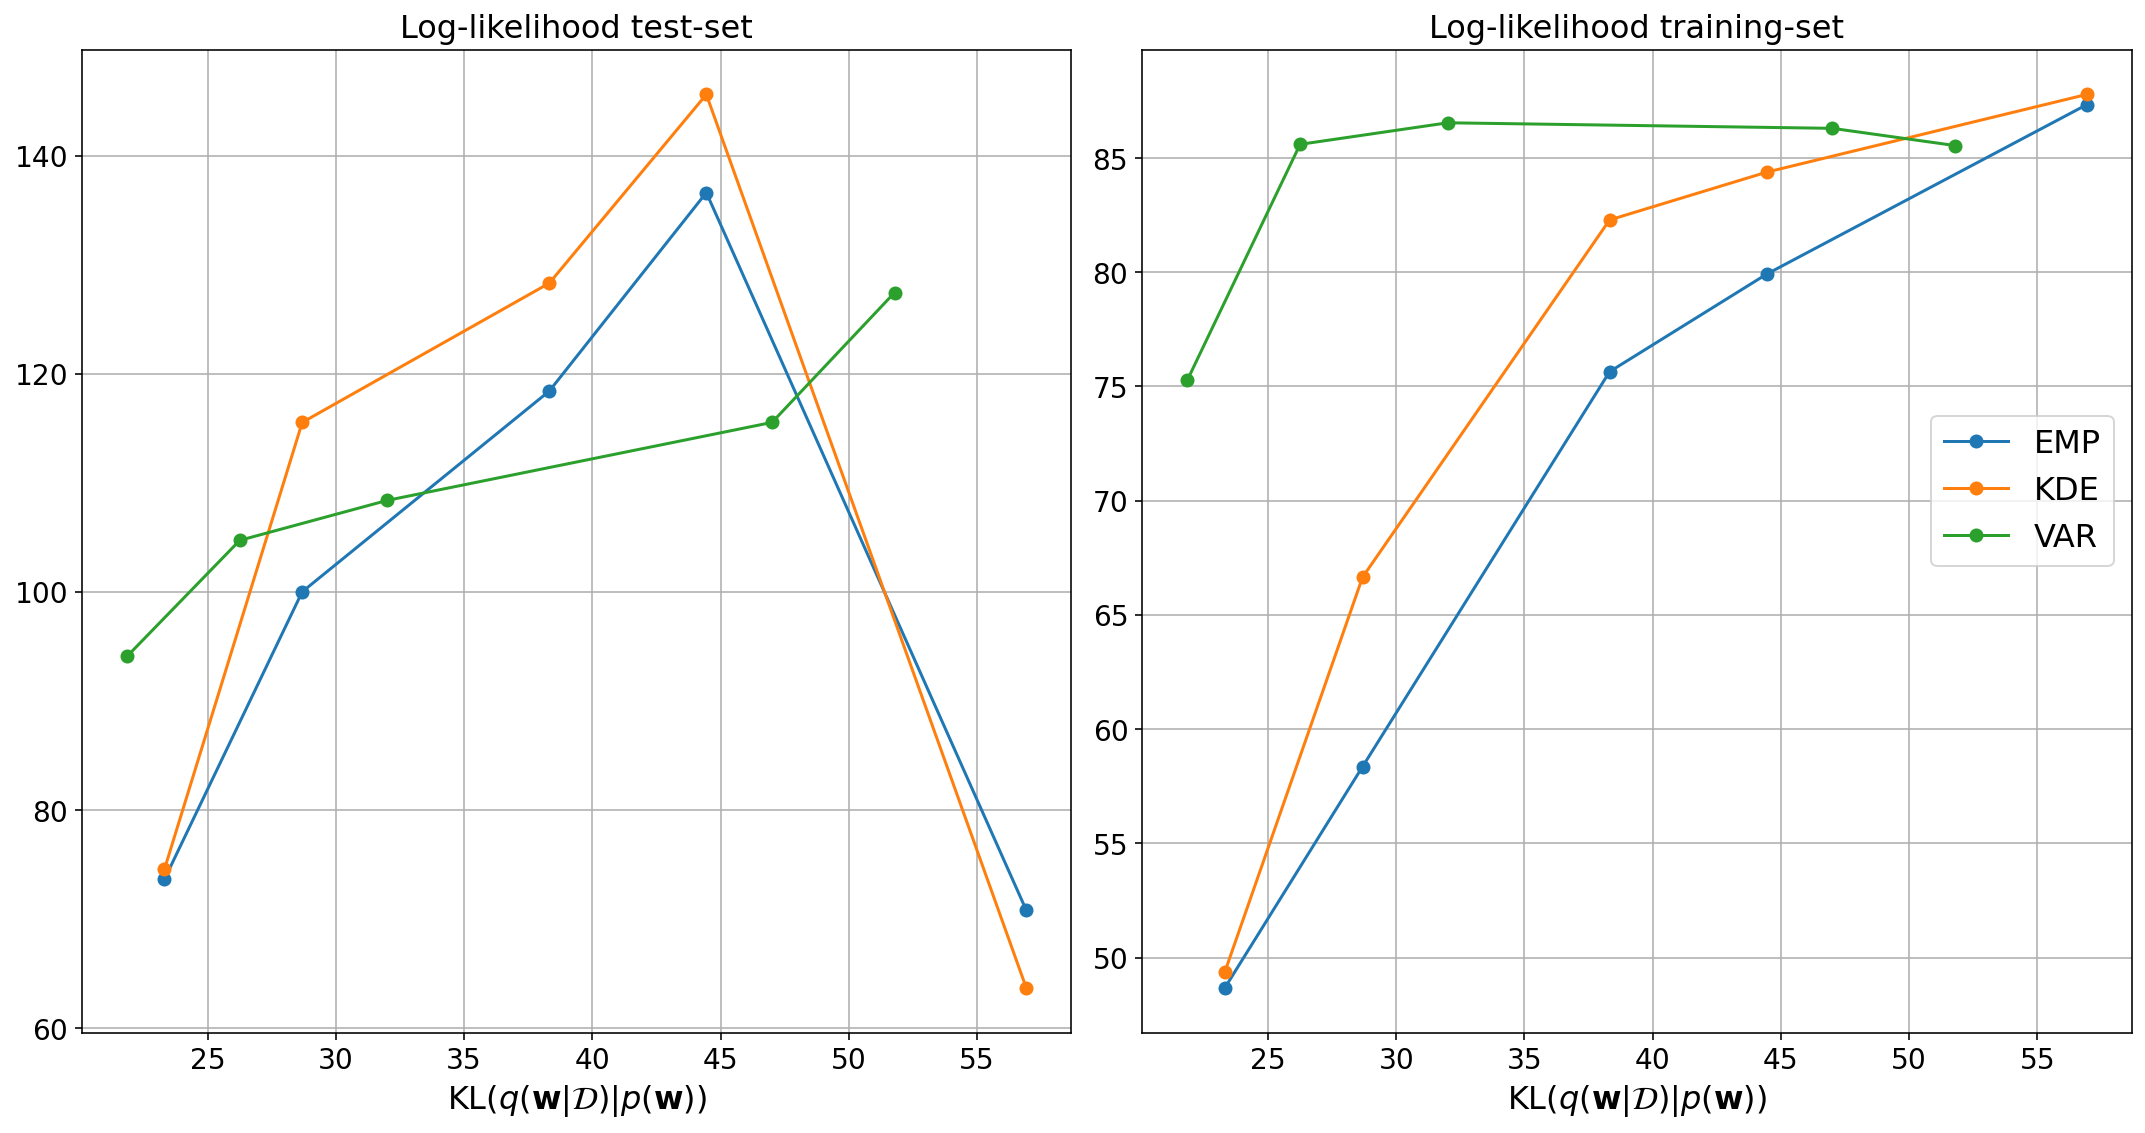

In [166]:
f, ax = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=False)
ax[0].plot(emp_kls, emp_test_lls, '-o')
ax[0].plot(emp_kls, kde_test_lls, '-o')
ax[0].plot(var_kls, var_test_lls, '-o')
ax[0].grid()
ax[0].set_xlabel(r'$\operatorname{KL}\left(q(\mathbf{w}|\mathcal{D}) \| p(\mathbf{w})\right)$', fontsize=16)
ax[1].plot(emp_kls, emp_train_lls, '-o')
ax[1].plot(emp_kls, kde_train_lls, '-o')
ax[1].plot(var_kls, var_train_lls, '-o')
ax[1].grid()
ax[1].set_xlabel(r'$\operatorname{KL}\left(q(\mathbf{w}|\mathcal{D}) \| p(\mathbf{w})\right)$', fontsize=16)
ax[0].set_title('Log-likelihood test-set', fontsize=16)
ax[1].set_title('Log-likelihood training-set', fontsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].tick_params(axis='both', which='minor', labelsize=14)
ax[1].tick_params(axis='both', which='minor', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
f.legend(['EMP', 'KDE', 'VAR'], loc = (0.9, 0.5), ncol=1, fontsize=16)
f.tight_layout()

In [167]:
emp_expected_coding_efficiency = [compute_expected_coding_efficiency(kl) for kl in emp_kls]

In [168]:
var_expected_coding_efficiency = [compute_expected_coding_efficiency(kl) for kl in var_kls]

In [169]:
def compute_expected_coding_efficiency(kl, epsilon=0.2):
    K = (1 + epsilon) * kl
    return K + torch.log(K + 1) + 1

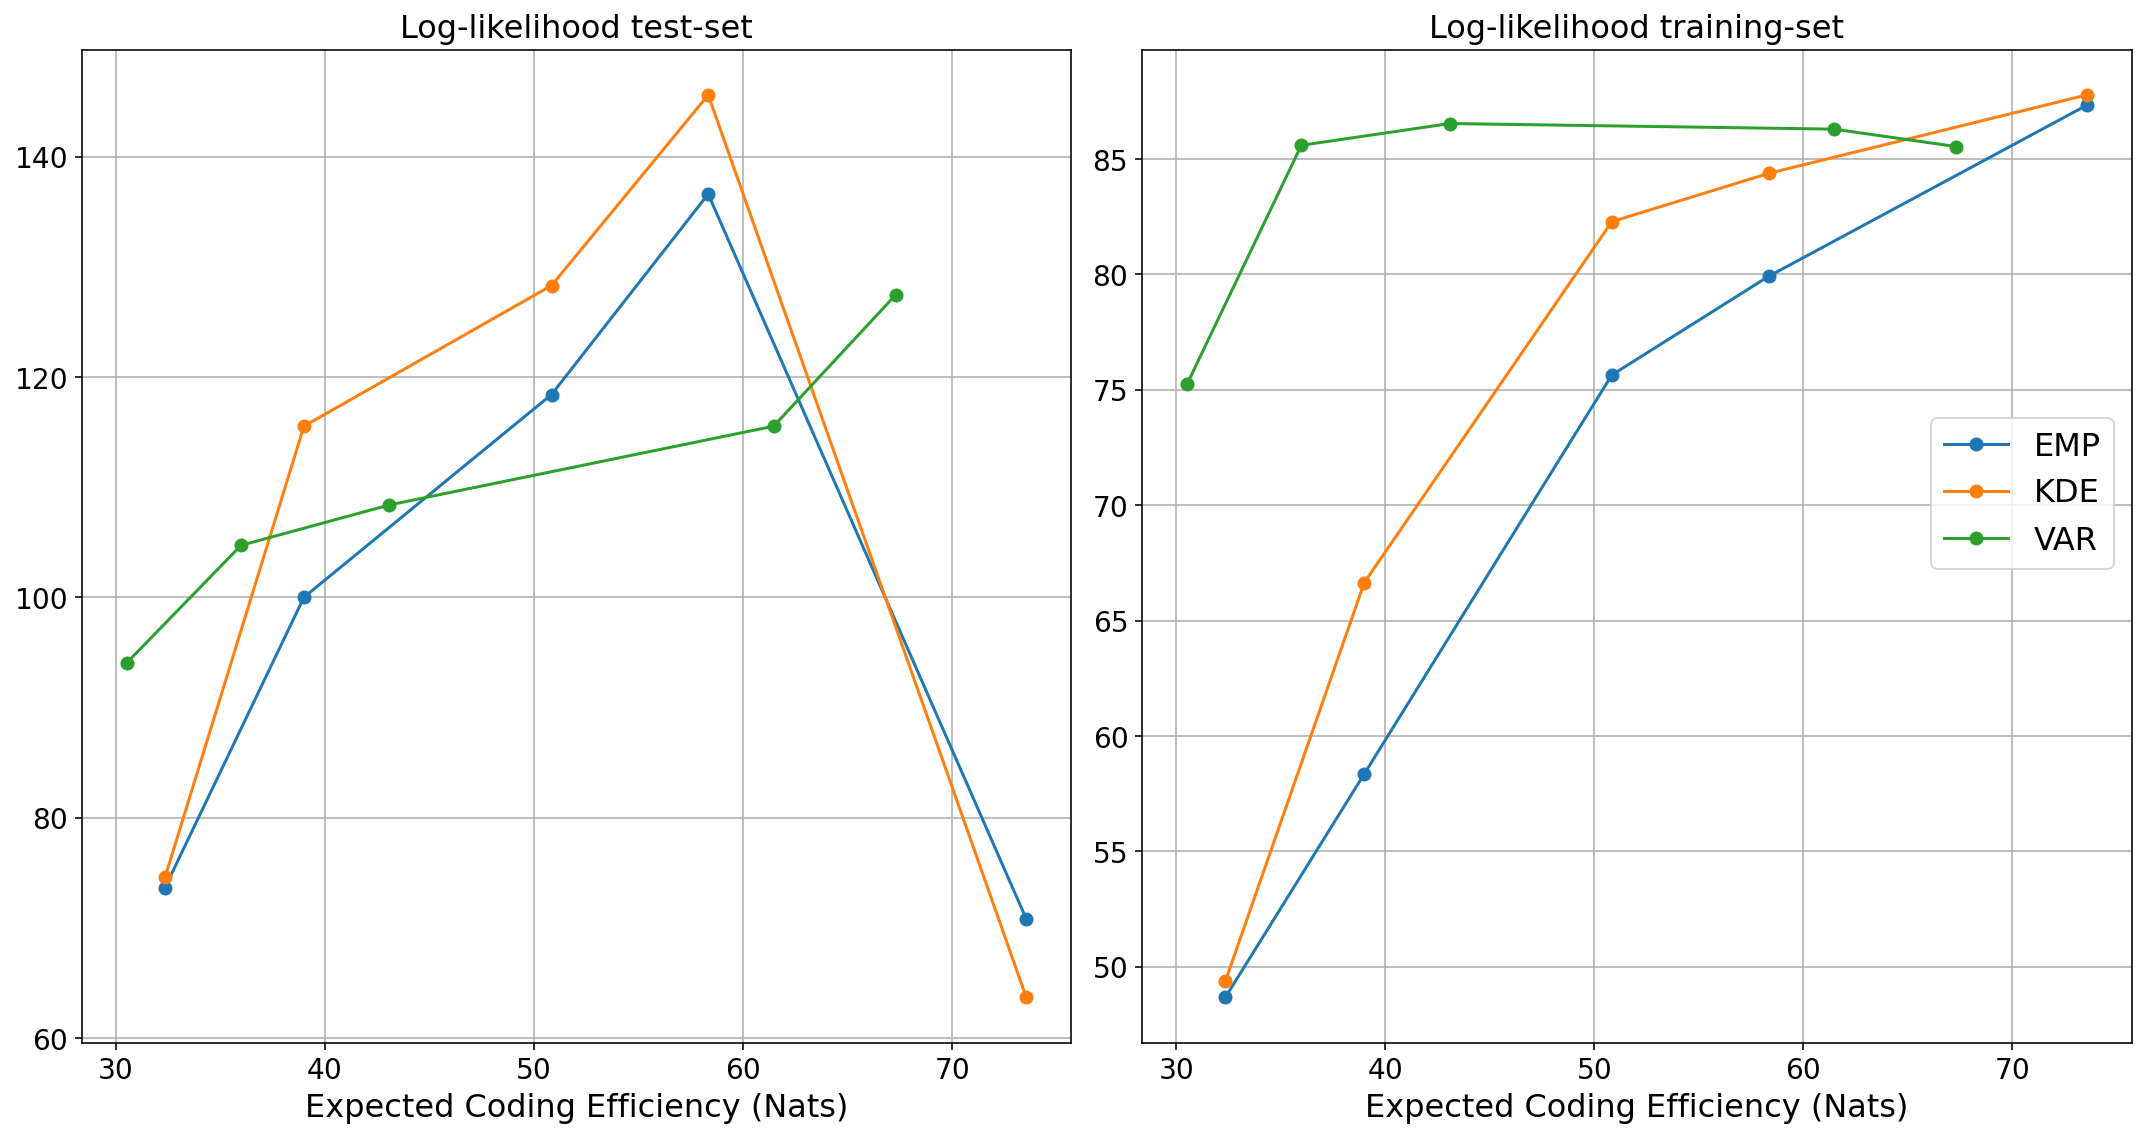

In [170]:
f, ax = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=False)
ax[0].plot(emp_expected_coding_efficiency, emp_test_lls, '-o')
ax[0].plot(emp_expected_coding_efficiency, kde_test_lls, '-o')
ax[0].plot(var_expected_coding_efficiency, var_test_lls, '-o')
ax[0].grid()
ax[0].set_xlabel('Expected Coding Efficiency (Nats)', fontsize=16)
ax[1].plot(emp_expected_coding_efficiency, emp_train_lls, '-o')
ax[1].plot(emp_expected_coding_efficiency, kde_train_lls, '-o')
ax[1].plot(var_expected_coding_efficiency, var_train_lls, '-o')
ax[1].grid()
ax[1].set_xlabel('Expected Coding Efficiency (Nats)', fontsize=16)
ax[0].set_title('Log-likelihood test-set', fontsize=16)
ax[1].set_title('Log-likelihood training-set', fontsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].tick_params(axis='both', which='minor', labelsize=14)
ax[1].tick_params(axis='both', which='minor', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
f.legend(['EMP', 'KDE', 'VAR'], loc = (0.9, 0.5), ncol=1, fontsize=16)
f.tight_layout()